## Code to make Fig S1
Elena Savidge
<br>
3 Aug 2023

In [1]:
# import rasterio
# from rasterio.plot import show
import matplotlib.pyplot as plt
import cartopy
#import rioxarray as rxr
import xarray as xr
import cmocean
from pyhdf.SD import SD, SDC
import cartopy.crs as ccrs
import pandas as pd
import numpy as np
import pyproj
from pyproj import Proj, transform, CRS
# import rasterio as rio
# from rasterio.plot import show
from glob import glob
from matplotlib.collections import PatchCollection
from shapely.geometry import Point, Polygon
import geopandas as gpd
import scipy
from scipy import ndimage
from cartopy.geodesic import Geodesic
import datetime
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm

/opt/anaconda3/envs/polyarea/lib/python3.11/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [2]:
# NOTE: need dir to be set up this way for pyproj to work
pyproj.datadir.set_data_dir('/opt/anaconda3/envs/sealenv/share/proj') 

/opt/anaconda3/envs/polyarea/lib/python3.11/site-packages/pyproj/datadir.py:38: UserWarning: pyproj unable to set database path.
  _global_context_set_data_dir()


In [3]:
pwd

'/Users/elenasavidge/Documents/Documents - Elena’s MacBook Pro/PhD_Ch2/manuscriptcode_2'

In [4]:
cd ../polynyatimeseries

/Users/elenasavidge/Documents/Documents - Elena’s MacBook Pro/PhD_Ch2/polynyatimeseries


## Read in data

In [5]:
ther_pixel = pd.read_pickle('../manuscriptcode_2/thermal_area_effectivepixel.pkl') # don't need thermal for this fig b/c not in intervals of interest
vis_pixel = pd.read_pickle('../manuscriptcode_2/visible_area_effectivepixel')  #doesnt matter if save .pkl or not

### 1. 2005/02/17

In [62]:
# Make list of all MOD09 files in folder
MODfiles = glob('20050217/MYD09.A2005048.2120.006.2015099213644.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

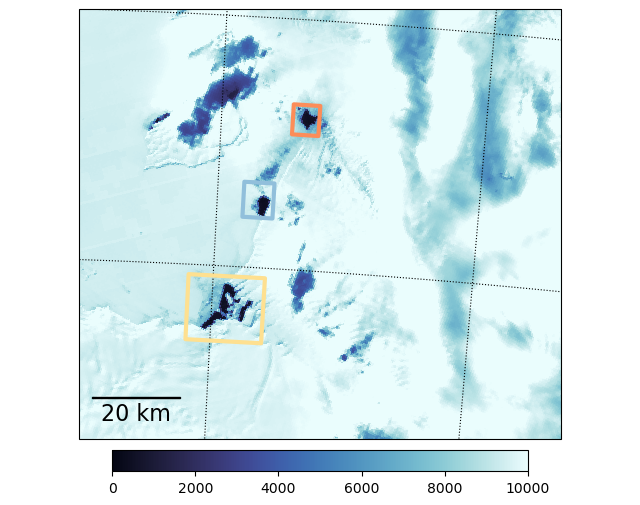

In [68]:
#llcrnrlat=-75.3;urcrnrlat=-74.55;llcrnrlon=-102.7;urcrnrlon=-100 # PIG same as seal
llcrnrlat=-75.3;urcrnrlat=-74.5;llcrnrlon=-103;urcrnrlon=-99.5 # PIG same as seal

fig,ax = plt.subplots(figsize=(8,6)) # give two axes 

plt.axis('off')
m = plt.axes(projection=ccrs.SouthPolarStereo(central_longitude=-105.0))
m.set_extent([llcrnrlon, urcrnrlon, llcrnrlat, urcrnrlat], ccrs.PlateCarree())
#m.add_geometries(land['geometry'], crs=ccrs.PlateCarree(),facecolor='None', edgecolor='k')
gl = m.gridlines(draw_labels=True,xlocs=[-110,-108,-106,-104,-102,-100],ylocs=[-75.5,-75,-74.5,-74,-73,-72,-71],y_inline=False,color='k',linestyle=':')
#gl = m.gridlines(draw_labels=True,xlocs=[-110,-108,-106,-104,-102,-100],ylocs=[-75,-74,-73,-72,-71],y_inline=False,color='k',linestyle=':')
gl.bottom_labels = gl.right_labels = gl.top_labels = gl.left_labels = False


data = m.pcolormesh(lon250,lat250,B1,transform=ccrs.PlateCarree(),cmap=cmocean.cm.ice,vmin=0,vmax=10000)

cb = plt.colorbar(data,fraction=0.045,pad=0.025,orientation='horizontal')#,shrink=0.84)


# Add bounding boxes (can comment this out)
# 1
patches = []
zone = np.array([[-102.19,-75.15],[-101.60,-75.15],[-101.60,-75.02],[-102.19,-75.02]])
patches.append(Polygon(zone))
#m.add_collection(PatchCollection(patches, transform=ccrs.PlateCarree(), facecolor = 'none', edgecolor='orangered', linewidths=3, linestyle='dashed',zorder=5))
m.add_geometries(patches, crs=ccrs.PlateCarree(),facecolor = 'none', edgecolor='#fee090', linewidths=3, linestyle='-',zorder=5)
# 2
patches = []
zone = np.array([[-101.80,-74.90],[-101.57,-74.90],[-101.57,-74.83],[-101.80,-74.83]])
patches.append(Polygon(zone))
#m.add_collection(PatchCollection(patches, transform=ccrs.PlateCarree(), facecolor = 'none', edgecolor='orangered', linewidths=3, linestyle='dashed',zorder=5))
m.add_geometries(patches, crs=ccrs.PlateCarree(),facecolor = 'none', edgecolor='#91bfdb', linewidths=3, linestyle='-',zorder=5)
# 3
patches = []
zone = np.array([[-101.46,-74.73],[-101.26,-74.73],[-101.26,-74.67],[-101.46,-74.67]])
patches.append(Polygon(zone))
#m.add_collection(PatchCollection(patches, transform=ccrs.PlateCarree(), facecolor = 'none', edgecolor='orangered', linewidths=3, linestyle='dashed',zorder=5))
m.add_geometries(patches, crs=ccrs.PlateCarree(),facecolor = 'none', edgecolor='#fc8d59', linewidths=3, linestyle='-',zorder=5)

# add scale bar
fontprops = fm.FontProperties(size=16)
scalebar = AnchoredSizeBar(m.transData,
                           20000, '20 km', 'lower left', 
                           pad=0.5,
                           color='k',
                           frameon=False,
                           size_vertical=250,
                           fill_bar=True,
                           sep=3.5,
                           fontproperties=fontprops)

m.add_artist(scalebar)

#plt.savefig('dnthresh_og20050217.jpg', format='jpg', dpi=400)


In [19]:
# Run this one at the time for each bound, e.g., figure_bounds, west_bounds... while commenting out the rest

def modis_to_xarray(longitude,latitude,bandvals):
    
    '''Extracts modis lat, lon, B1 and subsets figure into xarray'''
    
    # Convert input data from pandas dataframe to xarray dataArray for easier use and less memory intensive
    data_xr = xr.DataArray(bandvals,dims=["y","x"], coords={"latitude": (["y", "x"],latitude), "longitude": (["y", "x"],longitude)})
    
    # Subset entire modis image to PIG bounds and store output for area calc fct
    #figure_bounds = data_xr.where((data_xr.longitude>-102.7)&(data_xr.longitude<-100) & (data_xr.latitude>-75.3)&(data_xr.latitude<-74.55),drop=True)
    #west_bounds = data_xr.where((data_xr.longitude>-102.19)&(data_xr.longitude<-101.60) & (data_xr.latitude>-75.15)&(data_xr.latitude<-75.02),drop=True)
    #mid_bounds = data_xr.where((data_xr.longitude>-101.80)&(data_xr.longitude<-101.57) & (data_xr.latitude>-74.90)&(data_xr.latitude<-74.83),drop=True)
    east_bounds = data_xr.where((data_xr.longitude>-101.46)&(data_xr.longitude<-101.26) & (data_xr.latitude>-74.73)&(data_xr.latitude<-74.67),drop=True)


    #return figure_bounds
    #return west_bounds
    #return mid_bounds
    return east_bounds

In [11]:
figure_bounds = modis_to_xarray(lon250,lat250,B1)

(array([    0.,  5000., 10000., 15000., 20000., 25000., 30000., 35000.,
        40000.]),
 [Text(0, 0.0, '0'),
  Text(0, 5000.0, '5000'),
  Text(0, 10000.0, '10000'),
  Text(0, 15000.0, '15000'),
  Text(0, 20000.0, '20000'),
  Text(0, 25000.0, '25000'),
  Text(0, 30000.0, '30000'),
  Text(0, 35000.0, '35000'),
  Text(0, 40000.0, '40000')])

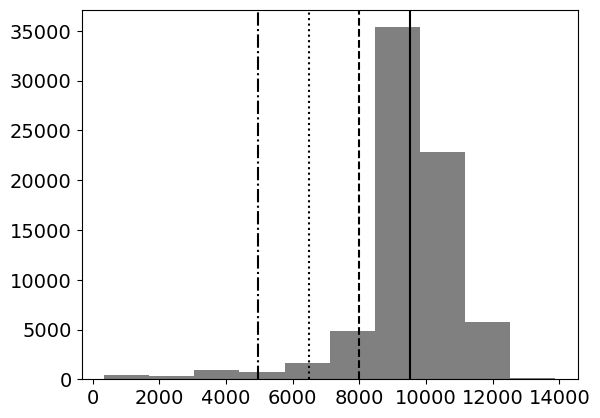

In [12]:
# histogram of subsetted image

plt.hist(figure_bounds.values.flatten(),color='gray')
plt.axvline(figure_bounds.mean(),c='k')
plt.axvline(figure_bounds.mean()-1*figure_bounds.std(),linestyle='--',c='k')
plt.axvline(figure_bounds.mean()-2*figure_bounds.std(),linestyle=':',c='k')
plt.axvline(figure_bounds.mean()-3*figure_bounds.std(),linestyle='-.',c='k')
plt.xticks(fontsize=14);plt.yticks(fontsize=14)

#plt.savefig('hist_dnthresh_og20050217.jpg', format='jpg', dpi=400)

In [14]:
west_bounds = modis_to_xarray(lon250,lat250,B1)

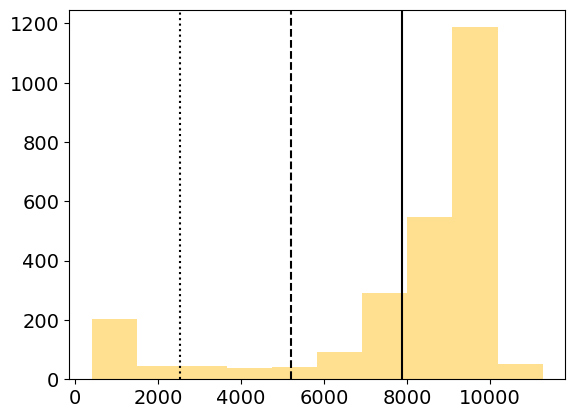

In [15]:
# histogram of subsetted image

plt.hist(west_bounds.values.flatten(),color='#fee090')
plt.xticks(fontsize=14);plt.yticks(fontsize=14)
plt.axvline(west_bounds.mean(),c='k')
plt.axvline(west_bounds.mean()-1*west_bounds.std(),linestyle='--',c='k')
plt.axvline(west_bounds.mean()-2*west_bounds.std(),linestyle=':',c='k')

#plt.savefig('hist_west_og20050217.jpg', format='jpg', dpi=400)

In [17]:
mid_bounds = modis_to_xarray(lon250,lat250,B1)

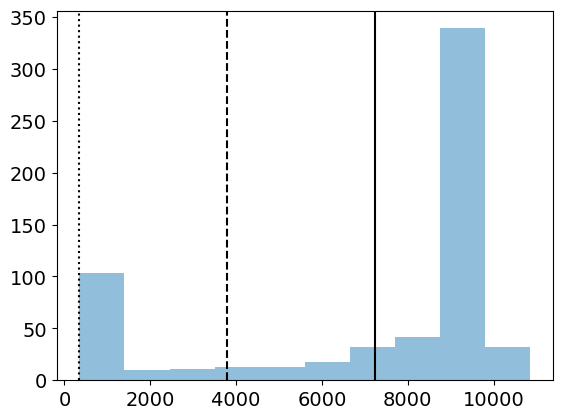

In [18]:
# histogram of subsetted image

plt.hist(mid_bounds.values.flatten(),color='#91bfdb')
plt.xticks(fontsize=14);plt.yticks(fontsize=14)
plt.axvline(mid_bounds.mean(),c='k')
plt.axvline(mid_bounds.mean()-1*mid_bounds.std(),linestyle='--',c='k')
plt.axvline(mid_bounds.mean()-2*mid_bounds.std(),linestyle=':',c='k')

#plt.savefig('hist_mid_og20050217.jpg', format='jpg', dpi=400)

In [20]:
east_bounds = modis_to_xarray(lon250,lat250,B1)

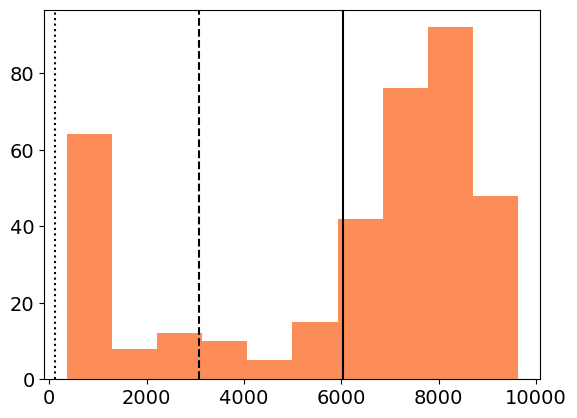

In [21]:
# histogram of subsetted image

plt.hist(east_bounds.values.flatten(),color='#fc8d59')
plt.xticks(fontsize=14);plt.yticks(fontsize=14)
plt.axvline(east_bounds.mean(),c='k')
plt.axvline(east_bounds.mean()-1*east_bounds.std(),linestyle='--',c='k')
plt.axvline(east_bounds.mean()-2*east_bounds.std(),linestyle=':',c='k')

#plt.savefig('hist_east_og20050217.jpg', format='jpg', dpi=400)

### 2. 2006/03/02

In [6]:
# Make list of all MOD09 files in folder
MODfiles = glob('20060302/MOD09.A2006061.1625.006.2015114013148.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B1 = (mod09.select('250m Surface Reflectance Band 1')[:])
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

# upsample 1 km lat, lon to 250 m - to match resolution of visible bands
lat250,lon250 = scipy.ndimage.zoom(lat, 4, order=1),scipy.ndimage.zoom(lon, 4, order=1)

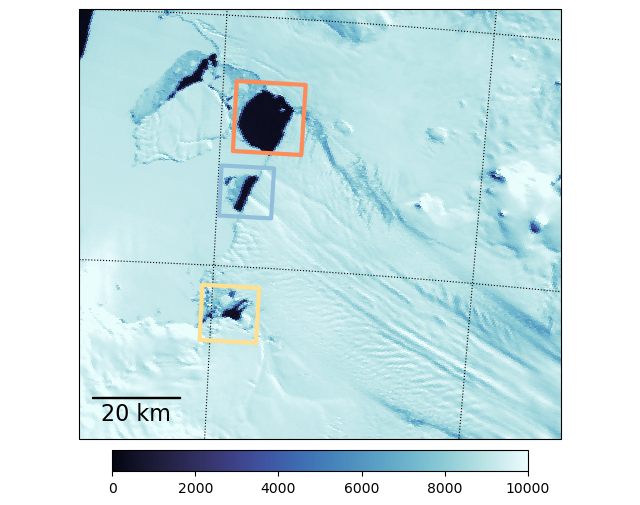

In [7]:
#llcrnrlat=-75.3;urcrnrlat=-74.55;llcrnrlon=-102.7;urcrnrlon=-100 # PIG same as seal
llcrnrlat=-75.3;urcrnrlat=-74.5;llcrnrlon=-103;urcrnrlon=-99.5 # PIG same as seal

fig,ax = plt.subplots(figsize=(8,6)) # give two axes 

plt.axis('off')
m = plt.axes(projection=ccrs.SouthPolarStereo(central_longitude=-105.0))
m.set_extent([llcrnrlon, urcrnrlon, llcrnrlat, urcrnrlat], ccrs.PlateCarree())
#m.add_geometries(land['geometry'], crs=ccrs.PlateCarree(),facecolor='None', edgecolor='k')
gl = m.gridlines(draw_labels=True,xlocs=[-110,-108,-106,-104,-102,-100],ylocs=[-75.5,-75,-74.5,-74,-73,-72,-71],y_inline=False,color='k',linestyle=':')
#gl = m.gridlineas(draw_labels=True,xlocs=[-110,-108,-106,-104,-102,-100],ylocs=[-75,-74,-73,-72,-71],y_inline=False,color='k',linestyle=':')
gl.bottom_labels = gl.right_labels = gl.top_labels = gl.left_labels = False


data = m.pcolormesh(lon250,lat250,B1,transform=ccrs.PlateCarree(),cmap=cmocean.cm.ice,vmin=0,vmax=10000)

cb = plt.colorbar(data,fraction=0.045,pad=0.025,orientation='horizontal')#,shrink=0.84)


# Add bounding boxes (can comment this out)
# 1
patches = []
zone = np.array([[-102.08,-75.15],[-101.64,-75.15],[-101.64,-75.04],[-102.08,-75.04]])
patches.append(Polygon(zone))
#m.add_collection(PatchCollection(patches, transform=ccrs.PlateCarree(), facecolor = 'none', edgecolor='orangered', linewidths=3, linestyle='dashed',zorder=5))
m.add_geometries(patches, crs=ccrs.PlateCarree(),facecolor = 'none', edgecolor='#fee090', linewidths=3, linestyle='-',zorder=5)
# 2
patches = []
zone = np.array([[-101.98,-74.90],[-101.58,-74.90],[-101.58,-74.80],[-101.98,-74.80]])
patches.append(Polygon(zone))
#m.add_collection(PatchCollection(patches, transform=ccrs.PlateCarree(), facecolor = 'none', edgecolor='orangered', linewidths=3, linestyle='dashed',zorder=5))
m.add_geometries(patches, crs=ccrs.PlateCarree(),facecolor = 'none', edgecolor='#91bfdb', linewidths=3, linestyle='-',zorder=5)
# 3
patches = []
zone = np.array([[-101.90,-74.77],[-101.38,-74.77],[-101.38,-74.63],[-101.90,-74.63]])
patches.append(Polygon(zone))
#m.add_collection(PatchCollection(patches, transform=ccrs.PlateCarree(), facecolor = 'none', edgecolor='orangered', linewidths=3, linestyle='dashed',zorder=5))
m.add_geometries(patches, crs=ccrs.PlateCarree(),facecolor = 'none', edgecolor='#fc8d59', linewidths=3, linestyle='-',zorder=5)

# add scale bar
fontprops = fm.FontProperties(size=16)
scalebar = AnchoredSizeBar(m.transData,
                           20000, '20 km', 'lower left', 
                           pad=0.5,
                           color='k',
                           frameon=False,
                           size_vertical=250,
                           fill_bar=True,
                           sep=3.5,
                           fontproperties=fontprops)

m.add_artist(scalebar)

#plt.savefig('dnthresh_og20060302.jpg', format='jpg', dpi=400)


In [47]:
def modis_to_xarray(longitude,latitude,bandvals):
    
    '''Extracts modis lat, lon, B1 and subsets figure into xarray'''
    
    # Convert input data from pandas dataframe to xarray dataArray for easier use and less memory intensive
    data_xr = xr.DataArray(bandvals,dims=["y","x"], coords={"latitude": (["y", "x"],latitude), "longitude": (["y", "x"],longitude)})
    
    # Subset entire modis image to PIG bounds and store output for area calc fct
    #figure_bounds = data_xr.where((data_xr.longitude>-102.7)&(data_xr.longitude<-100) & (data_xr.latitude>-75.3)&(data_xr.latitude<-74.55),drop=True)
    #east_bounds = data_xr.where((data_xr.longitude>-101.90)&(data_xr.longitude<-101.38) & (data_xr.latitude>-74.77)&(data_xr.latitude<-74.63),drop=True)
    #mid_bounds = data_xr.where((data_xr.longitude>-101.98)&(data_xr.longitude<-101.53) & (data_xr.latitude>-74.90)&(data_xr.latitude<-74.80),drop=True)
    west_bounds = data_xr.where((data_xr.longitude>-102.08)&(data_xr.longitude<-101.64) & (data_xr.latitude>-75.15)&(data_xr.latitude<-75.04),drop=True)


    #return figure_bounds
    #return east_bounds
    #return mid_bounds
    return west_bounds

In [38]:
figure_bounds = modis_to_xarray(lon250,lat250,B1)

(array([    0., 10000., 20000., 30000., 40000., 50000., 60000.]),
 [Text(0, 0.0, '0'),
  Text(0, 10000.0, '10000'),
  Text(0, 20000.0, '20000'),
  Text(0, 30000.0, '30000'),
  Text(0, 40000.0, '40000'),
  Text(0, 50000.0, '50000'),
  Text(0, 60000.0, '60000')])

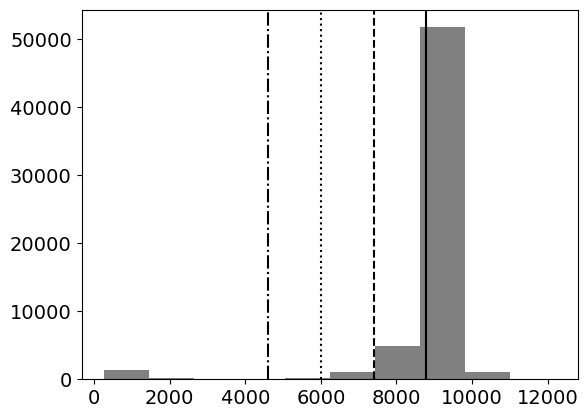

In [39]:
# histogram of subsetted image

plt.hist(figure_bounds.values.flatten(),color='gray')
plt.axvline(figure_bounds.mean(),c='k')
plt.axvline(figure_bounds.mean()-1*figure_bounds.std(),linestyle='--',c='k')
plt.axvline(figure_bounds.mean()-2*figure_bounds.std(),linestyle=':',c='k')
plt.axvline(figure_bounds.mean()-3*figure_bounds.std(),linestyle='-.',c='k')
plt.xticks(fontsize=14);plt.yticks(fontsize=14)

#plt.savefig('hist_dnthresh_og20050217.jpg', format='jpg', dpi=400)

In [48]:
west_bounds = modis_to_xarray(lon250,lat250,B1)

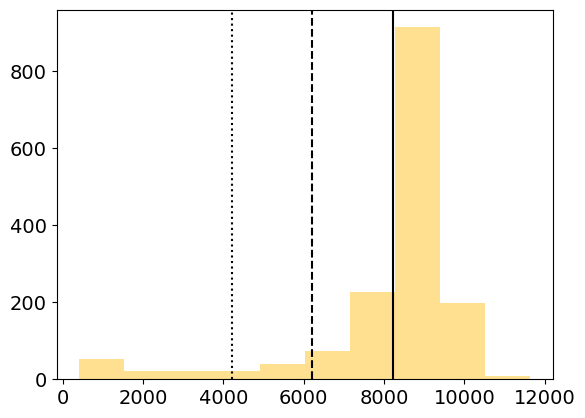

In [49]:
# histogram of subsetted image

plt.hist(west_bounds.values.flatten(),color='#fee090')
plt.xticks(fontsize=14);plt.yticks(fontsize=14)
plt.axvline(west_bounds.mean(),c='k')
plt.axvline(west_bounds.mean()-1*west_bounds.std(),linestyle='--',c='k')
plt.axvline(west_bounds.mean()-2*west_bounds.std(),linestyle=':',c='k')

#plt.savefig('hist_west_og20050217.jpg', format='jpg', dpi=400)

In [45]:
mid_bounds = modis_to_xarray(lon250,lat250,B1)

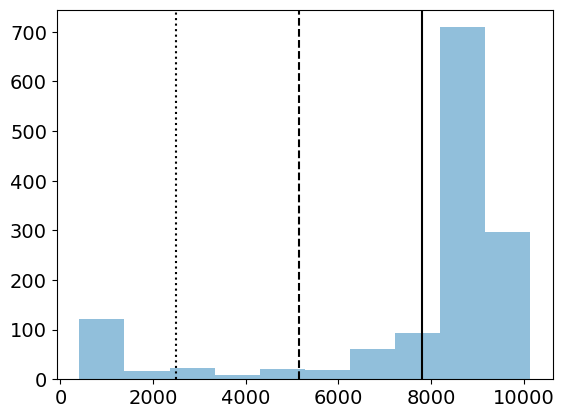

In [46]:
# histogram of subsetted image

plt.hist(mid_bounds.values.flatten(),color='#91bfdb')
plt.xticks(fontsize=14);plt.yticks(fontsize=14)
plt.axvline(mid_bounds.mean(),c='k')
plt.axvline(mid_bounds.mean()-1*mid_bounds.std(),linestyle='--',c='k')
plt.axvline(mid_bounds.mean()-2*mid_bounds.std(),linestyle=':',c='k')

#plt.savefig('hist_mid_og20050217.jpg', format='jpg', dpi=400)

In [41]:
east_bounds = modis_to_xarray(lon250,lat250,B1)

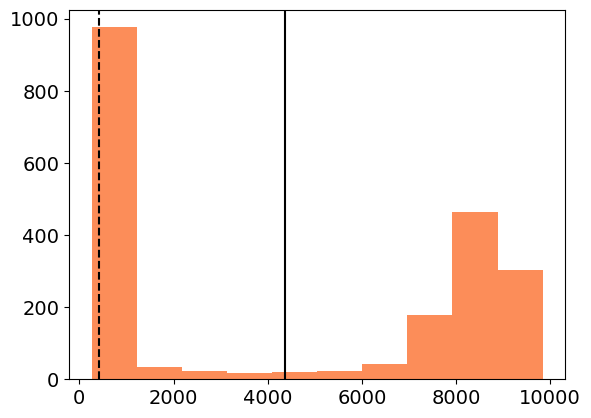

In [43]:
# histogram of subsetted image

plt.hist(east_bounds.values.flatten(),color='#fc8d59')
plt.xticks(fontsize=14);plt.yticks(fontsize=14)
plt.axvline(east_bounds.mean(),c='k')
plt.axvline(east_bounds.mean()-1*east_bounds.std(),linestyle='--',c='k')
#plt.axvline(east_bounds.mean()-2*east_bounds.std(),linestyle=':',c='k')

#plt.savefig('hist_east_og20050217.jpg', format='jpg', dpi=400)

## Save all panels and make fig

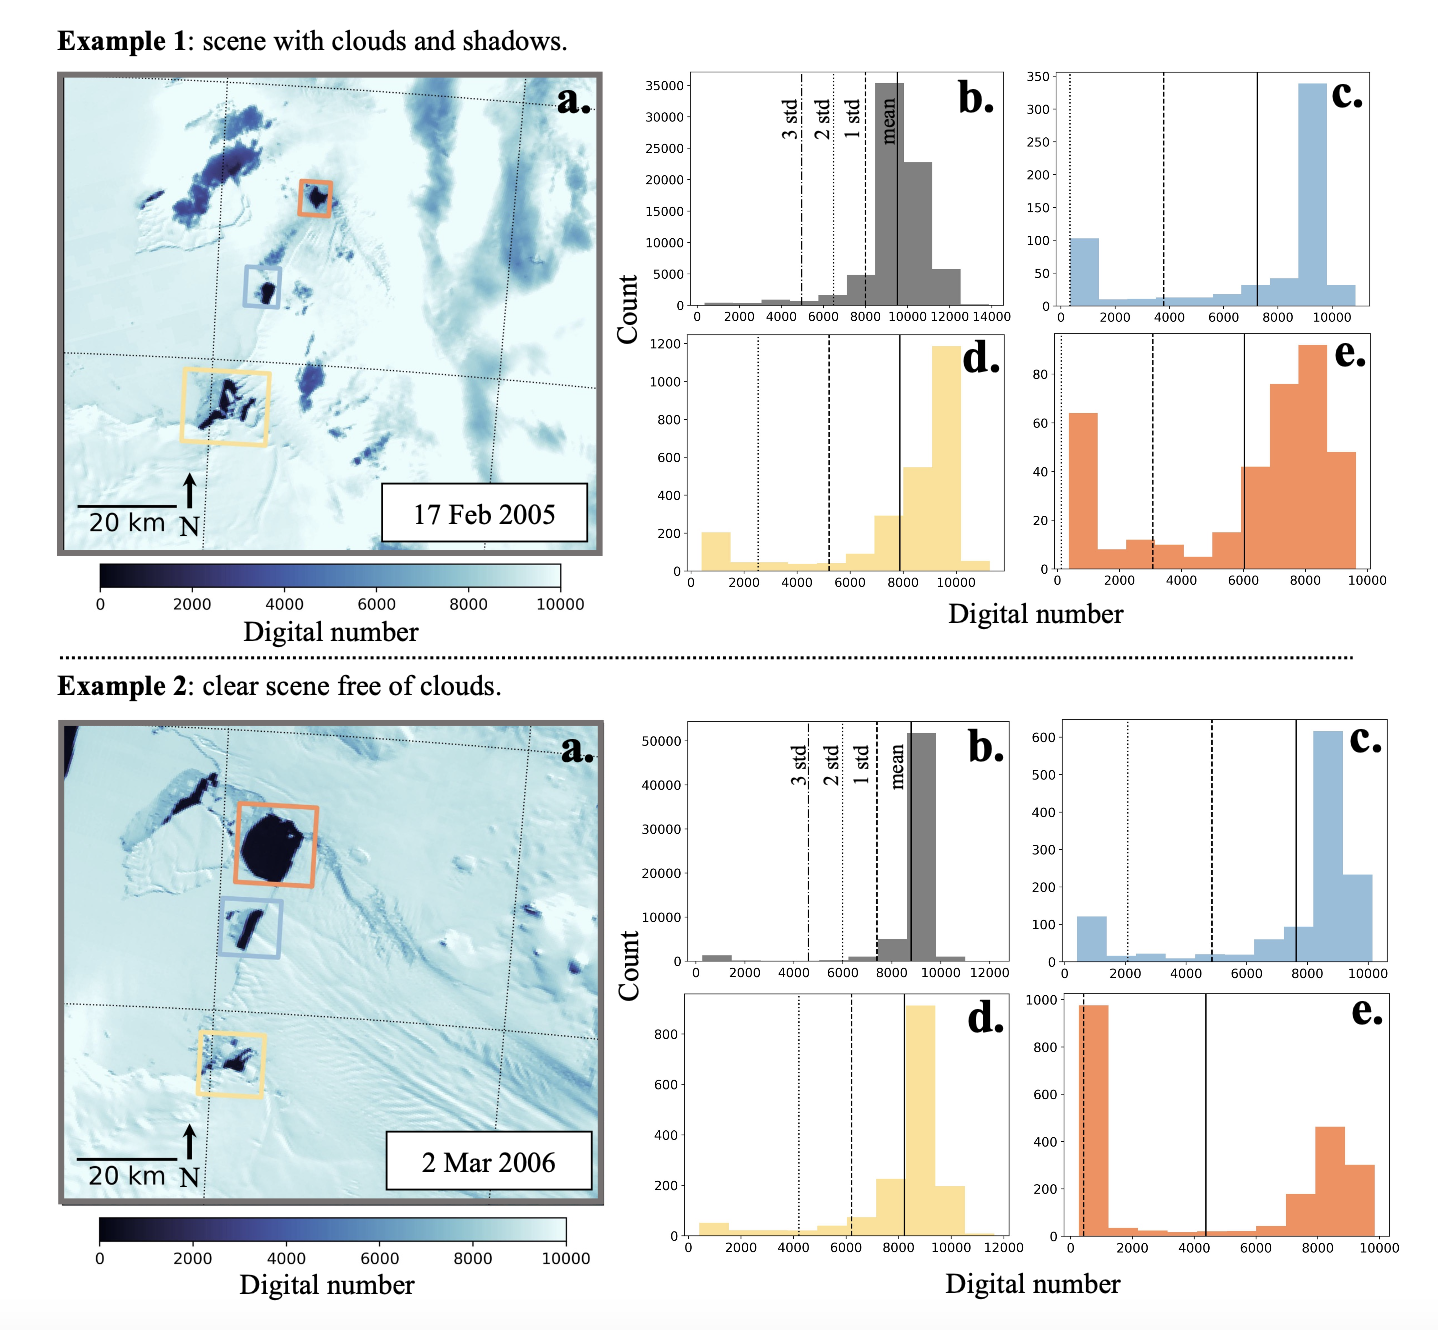